In [59]:
import dask.dataframe as dd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [62]:
dir = "./data/random/"
real = dd.read_parquet(dir+"data.parquet", columns=["spec","variant","real.tests", "real.downs", "size", "clocks"])
squished = dd.read_parquet(dir+"squished.parquet", columns=["spec","variant","approx.tests", "approx.downs"])
opti = dd.read_parquet(dir+"optimized.parquet", index=["spec"],columns=["variant","comb", "real.tests", "real.downs", "size"])
squished = squished.groupby(["spec", "variant"]).max()

real_max = real.groupby(["spec", "variant"]).max()

In [72]:
comparison_squished = real_max.join(squished, on=["spec", "variant"]).compute()
comparison_squished = comparison_squished.sort_values("clocks")

<AxesSubplot:xlabel='spec'>

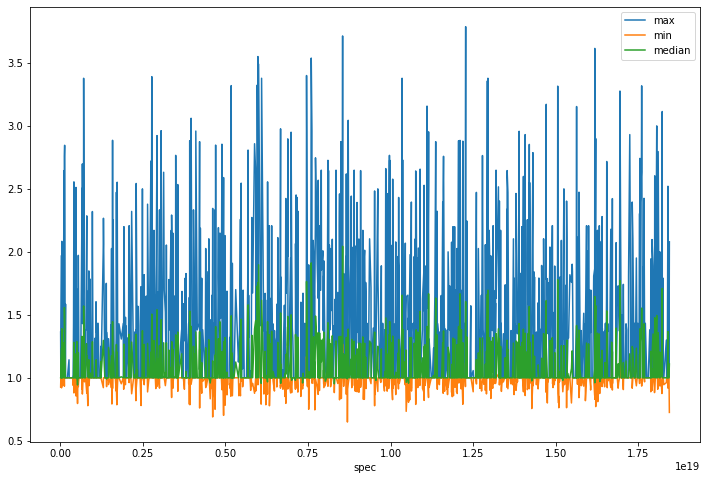

In [73]:
(comparison_squished["approx.tests"]/comparison_squished["real.tests"]).groupby("spec").agg(["max", "min", "median"]).plot(figsize=(12,8))

<AxesSubplot:xlabel='spec,variant'>

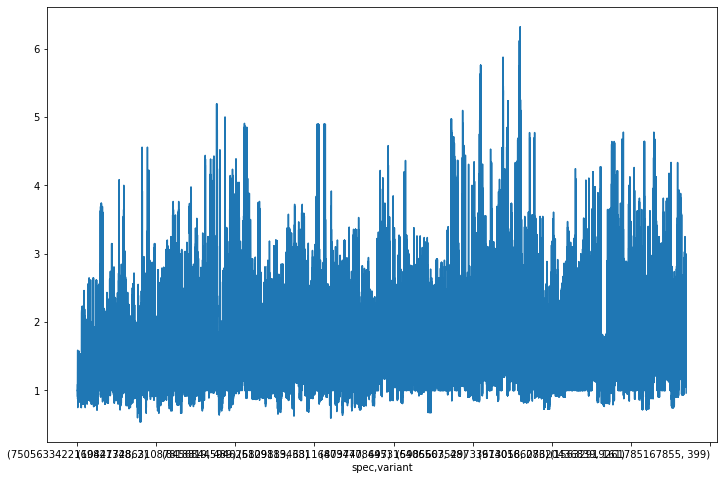

In [74]:
(comparison_squished["approx.downs"]/comparison_squished["real.downs"]).plot(figsize=(12,8))

In [75]:
opti_max = opti.groupby("spec").max()
real_statistics = real_max.groupby("spec").aggregate(["min", "max", "mean"])
compare = real_statistics.join(opti_max)
comparison = compare.compute()

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:xlabel='spec'>

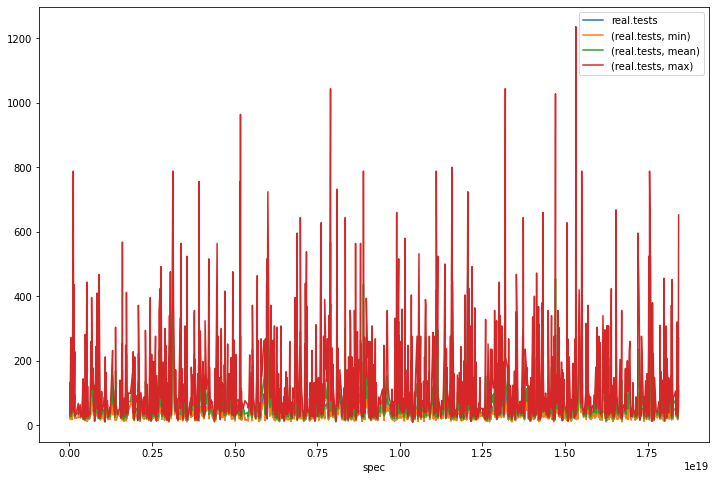

In [76]:
comparison[["real.tests", ("real.tests", "min"), ("real.tests", "mean"), ("real.tests", "max")]].plot(figsize=(12, 8))

In [77]:
comparison[comparison["real.tests"] > comparison[("real.tests", "mean")]]


,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)","(clocks, max)","(clocks, mean)",variant,comb,real.tests,real.downs,size
spec,,,,,,,,,,,,,,,,,
500462355658256262,26,28,27.333333,10,12,11.333333,3,3,3.0,4,4,4.0,2,3,28,12,3
885812250016532955,20,24,21.666667,8,11,9.333333,3,3,3.0,4,4,4.0,0,1,22,10,3
1462694375325526688,29,44,36.833333,10,17,13.500000,4,4,4.0,5,5,5.0,7,0,38,13,4
1554794547745907074,56,116,77.800000,21,44,29.400000,5,5,5.0,7,7,7.0,42,0,78,27,5
1956906736098458128,26,28,27.333333,10,12,11.333333,3,3,3.0,5,5,5.0,2,1,28,12,3
2067412624227517090,14,16,14.666667,6,8,6.666667,3,3,3.0,3,3,3.0,0,1,16,8,3
2957659948531691692,14,18,15.333333,6,9,7.000000,3,3,3.0,4,4,4.0,0,0,16,8,3
3258969424185659478,19,22,20.666667,7,9,8.000000,3,3,3.0,4,4,4.0,2,0,22,9,3
3896632082551647526,14,16,14.666667,6,8,6.666667,3,3,3.0,4,4,4.0,2,1,16,8,3


In [78]:
len(comparison[comparison["real.tests"] > comparison[("real.tests", "mean")]])/len(comparison)

0.02142857142857143

In [79]:
comparison[comparison["real.tests"] > comparison[("real.tests", "max")]]

,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)","(clocks, max)","(clocks, mean)",variant,comb,real.tests,real.downs,size
spec,,,,,,,,,,,,,,,,,


<AxesSubplot:xlabel='spec', ylabel='real.tests'>

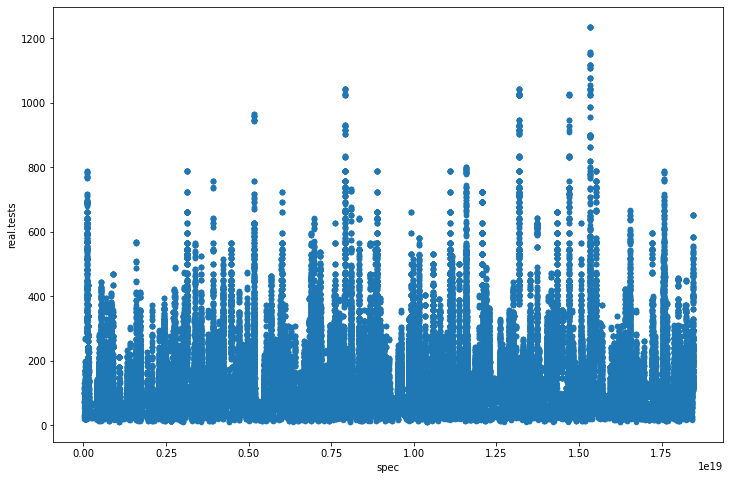

In [80]:
frame = real_max.compute()
frame.reset_index(inplace=True)
frame.plot.scatter(x="spec", y="real.tests", figsize=(12, 8))
